# Entrenamiento de Modelos de Clasificación: Ultrasonidos vs Sonidos Ambientales

Este notebook entrena modelos de machine learning y deep learning para clasificar automáticamente entre:
- **🌱 Ultrasonidos de plantas** (label=1): Señales bioactivas de interés
- **🌍 Sonidos ambientales** (label=0): Ruido de fondo a filtrar

## Dataset:
- **Fuente**: `plant_ultrasonic_dataset_balanced.csv`
- **Balanceado**: 50% ultrasonidos vs 50% ambientales
- **Multi-batch**: PUA.01 + PUA.02 para máxima robustez
- **Multi-canal**: 4 canales simultáneos (ch1, ch2, ch3, ch4)

## Enfoques de Modelado:
1. **Modelos Tradicionales**: SVM, Random Forest, XGBoost con características extraídas
2. **Deep Learning 1D**: CNN para formas de onda directas
3. **Deep Learning 2D**: CNN para espectrogramas
4. **Modelos Temporales**: LSTM/GRU para secuencias
5. **Ensemble**: Combinación de múltiples enfoques

In [1]:
# Importar librerías necesarias
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from pathlib import Path
import warnings
from tqdm import tqdm
import joblib
from datetime import datetime
import gc

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# XGBoost
try:
    import xgboost as xgb
    print("✅ XGBoost disponible")
except ImportError:
    print("⚠️  XGBoost no disponible")
    xgb = None

warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Configurar dispositivo para PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Dispositivo de cómputo: {device}")
print("📚 Librerías cargadas correctamente")

✅ XGBoost disponible
🔧 Dispositivo de cómputo: cpu
📚 Librerías cargadas correctamente


In [2]:
# Función auxiliar para sampling estratificado (corrige error de pandas)
def stratified_sample(df, n, label_col='label', random_state=42):
    """
    Realizar sampling estratificado manualmente
    """
    if n >= len(df):
        return df.sample(frac=1, random_state=random_state)
    
    # Verificar si hay múltiples clases
    unique_labels = df[label_col].unique()
    if len(unique_labels) <= 1:
        return df.sample(n=n, random_state=random_state)
    
    # Calcular muestras por clase
    label_counts = df[label_col].value_counts()
    proportions = label_counts / len(df)
    
    sampled_dfs = []
    remaining_n = n
    
    for i, (label, prop) in enumerate(proportions.items()):
        if i == len(proportions) - 1:  # Última clase, usar todo lo que queda
            n_class = remaining_n
        else:
            n_class = max(1, int(n * prop))  # Al menos 1 muestra por clase
        
        class_df = df[df[label_col] == label]
        if len(class_df) > 0:
            n_class = min(n_class, len(class_df))  # No más de lo que hay disponible
            sampled_class = class_df.sample(n=n_class, random_state=random_state)
            sampled_dfs.append(sampled_class)
            remaining_n -= n_class
    
    # Combinar y mezclar
    result = pd.concat(sampled_dfs, ignore_index=True)
    return result.sample(frac=1, random_state=random_state).reset_index(drop=True)

print("✅ Función de sampling estratificado implementada")

✅ Función de sampling estratificado implementada


## 1. Carga y Exploración del Dataset Balanceado

In [5]:
# Cargar dataset balanceado
dataset_path = "../data/plant_ultrasonic_dataset_balanced.csv"
df = pd.read_csv(dataset_path)

print(f"📊 Dataset cargado:")
print(f"   Muestras totales: {len(df):,}")
print(f"   Columnas: {len(df.columns)}")
print(f"   Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verificar balance
label_counts = df['label'].value_counts().sort_index()
print(f"\n🎯 Distribución de clases:")
print(f"   Ambientales (0): {label_counts[0]:,} ({label_counts[0]/len(df)*100:.1f}%)")
print(f"   Ultrasonidos (1): {label_counts[1]:,} ({label_counts[1]/len(df)*100:.1f}%)")

# Distribución por batch y canal
print(f"\n📈 Distribución por batch:")
batch_dist = df.groupby(['batch', 'label']).size().unstack(fill_value=0)
print(batch_dist)

print(f"\n📡 Distribución por canal:")
channel_dist = df.groupby(['channel', 'label']).size().unstack(fill_value=0)
print(channel_dist)

# Mostrar muestra del dataset
print(f"\n📄 Muestra del dataset:")
display_cols = ['filename', 'batch', 'session', 'channel', 'date', 'hour', 'label_text']
print(df[display_cols].head(10))

📊 Dataset cargado:
   Muestras totales: 11,660
   Columnas: 17
   Memoria: 8.97 MB

🎯 Distribución de clases:
   Ambientales (0): 5,830 (50.0%)
   Ultrasonidos (1): 5,830 (50.0%)

📈 Distribución por batch:
label      0     1
batch             
PUA.01  1375  1979
PUA.02  4455  3851

📡 Distribución por canal:
label       0     1
channel            
1        1502  1329
2        1431  1428
3        1482  1712
4        1415  1361

📄 Muestra del dataset:
                         filename   batch session  channel        date  hour  \
0  ch2PUA_2025-03-02_07-56-48.wav  PUA.02  PUA083        2  2025-03-02     7   
1  ch1PUA_2025-01-21_21-42-39.wav  PUA.01  PUA073        1  2025-01-21    21   
2  ch2PUA_2025-03-09_14-52-20.wav  PUA.02  PUA084        2  2025-03-09    14   
3  ch4PUA_2025-03-04_01-39-54.wav  PUA.02  PUA083        4  2025-03-04     1   
4  ch1PUA_2025-01-04_22-52-08.wav  PUA.01  PUA067        1  2025-01-04    22   
5  ch4PUA_2025-01-09_05-24-59.wav  PUA.01  PUA069        4  2025-01

## 2. Extracción de Características de Audio

In [6]:
def extract_audio_features(audio_path, duration=None, sr=22050):
    """
    Extraer características completas de un archivo de audio
    
    Args:
        audio_path: Ruta al archivo de audio
        duration: Duración máxima a cargar (None para completo)
        sr: Sample rate objetivo
        
    Returns:
        dict: Diccionario con características extraídas
    """
    try:
        # Cargar audio
        y, sr_original = librosa.load(audio_path, duration=duration, sr=sr)
        
        if len(y) == 0:
            return None
            
        features = {}
        
        # 1. Características temporales básicas
        features['duration'] = len(y) / sr
        features['rms_energy'] = np.sqrt(np.mean(y**2))
        features['max_amplitude'] = np.max(np.abs(y))
        features['zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y))
        
        # 2. Características espectrales
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        features['spectral_centroid_mean'] = np.mean(spectral_centroids)
        features['spectral_centroid_std'] = np.std(spectral_centroids)
        
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_rolloff_std'] = np.std(spectral_rolloff)
        
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
        features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
        
        # 3. MFCC (Mel-Frequency Cepstral Coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
        
        # 4. Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features['chroma_mean'] = np.mean(chroma)
        features['chroma_std'] = np.std(chroma)
        
        # 5. Mel spectrogram features
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        features['mel_spec_mean'] = np.mean(mel_spec)
        features['mel_spec_std'] = np.std(mel_spec)
        
        # 6. Tempo
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo
        
        # 7. Características de frecuencia específicas para ultrasonidos
        # Analizar energía en diferentes rangos de frecuencia
        fft = np.fft.fft(y)
        freqs = np.fft.fftfreq(len(fft), 1/sr)
        magnitude = np.abs(fft)
        
        # Rangos de frecuencia de interés
        low_freq_mask = (freqs >= 0) & (freqs < 1000)  # 0-1kHz
        mid_freq_mask = (freqs >= 1000) & (freqs < 10000)  # 1-10kHz
        high_freq_mask = (freqs >= 10000) & (freqs < sr//2)  # 10kHz+
        
        features['energy_low_freq'] = np.sum(magnitude[low_freq_mask])
        features['energy_mid_freq'] = np.sum(magnitude[mid_freq_mask])
        features['energy_high_freq'] = np.sum(magnitude[high_freq_mask])
        
        # Ratio de energía alta vs baja (importante para ultrasonidos)
        total_low_mid = features['energy_low_freq'] + features['energy_mid_freq']
        if total_low_mid > 0:
            features['high_freq_ratio'] = features['energy_high_freq'] / total_low_mid
        else:
            features['high_freq_ratio'] = 0
            
        return features
        
    except Exception as e:
        print(f"Error procesando {audio_path}: {e}")
        return None

print("✅ Función de extracción de características definida")

✅ Función de extracción de características definida


In [7]:
# Extraer características de una muestra pequeña primero para testing
sample_size = 100  # Empezar con muestra pequeña
df_sample = stratified_sample(df, n=sample_size, random_state=42)

print(f"🧪 Extrayendo características de {sample_size} archivos de muestra...")

features_list = []
labels = []
valid_indices = []

for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Procesando muestra"):
    audio_path = row['full_path']
    
    if Path(audio_path).exists():
        features = extract_audio_features(audio_path, duration=10.0)  # Primeros 10 segundos
        
        if features is not None:
            features_list.append(features)
            labels.append(row['label'])
            valid_indices.append(idx)
    else:
        print(f"⚠️  Archivo no encontrado: {audio_path}")

print(f"✅ Características extraídas de {len(features_list)} archivos")

if len(features_list) > 0:
    # Convertir a DataFrame
    features_df = pd.DataFrame(features_list)
    print(f"📊 Dimensiones de características: {features_df.shape}")
    print(f"📋 Características extraídas: {list(features_df.columns[:10])}...")
    
    # Verificar balance en la muestra
    sample_labels = pd.Series(labels)
    print(f"\n🎯 Balance en muestra:")
    print(sample_labels.value_counts())
else:
    print("❌ No se pudieron extraer características")

🧪 Extrayendo características de 100 archivos de muestra...


Procesando muestra: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.55it/s]

✅ Características extraídas de 100 archivos
📊 Dimensiones de características: (100, 45)
📋 Características extraídas: ['duration', 'rms_energy', 'max_amplitude', 'zero_crossing_rate', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_rolloff_mean', 'spectral_rolloff_std', 'spectral_bandwidth_mean', 'spectral_bandwidth_std']...

🎯 Balance en muestra:
0    50
1    50
Name: count, dtype: int64


## 3. Modelos Tradicionales de Machine Learning

In [8]:
# Preparar datos para modelos tradicionales
if len(features_list) > 0:
    X = features_df
    y = np.array(labels)
    
    # Eliminar características con NaN
    X = X.fillna(0)
    
    # Separar datos de entrenamiento y test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Normalizar características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"📊 Datos preparados:")
    print(f"   Entrenamiento: {X_train.shape}")
    print(f"   Test: {X_test.shape}")
    print(f"   Características: {X_train.shape[1]}")
    
    # Distribución de clases
    train_dist = pd.Series(y_train).value_counts().sort_index()
    test_dist = pd.Series(y_test).value_counts().sort_index()
    print(f"\n🎯 Distribución entrenamiento: {dict(train_dist)}")
    print(f"🎯 Distribución test: {dict(test_dist)}")
else:
    print("❌ No hay características para entrenar modelos")

📊 Datos preparados:
   Entrenamiento: (80, 45)
   Test: (20, 45)
   Características: 45

🎯 Distribución entrenamiento: {0: 40, 1: 40}
🎯 Distribución test: {0: 10, 1: 10}


In [9]:
# Definir y entrenar múltiples modelos tradicionales
if len(features_list) > 0:
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'SVM': SVC(kernel='rbf', random_state=42, probability=True),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }
    
    # Añadir XGBoost si está disponible
    if xgb is not None:
        models['XGBoost'] = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    
    # Entrenar y evaluar cada modelo
    results = {}
    trained_models = {}
    
    print("🚀 Entrenando modelos tradicionales...")
    
    for name, model in tqdm(models.items(), desc="Entrenando modelos"):
        print(f"\n📈 Entrenando {name}...")
        
        # Entrenar modelo
        model.fit(X_train_scaled, y_train)
        
        # Predicciones
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Métricas
        accuracy = model.score(X_test_scaled, y_test)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
        
        results[name] = {
            'accuracy': accuracy,
            'auc': auc_score,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        trained_models[name] = model
        
        print(f"   Accuracy: {accuracy:.3f}")
        print(f"   AUC: {auc_score:.3f}")
        print(f"   CV Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    print("\n✅ Entrenamiento completado")
else:
    print("❌ No se pueden entrenar modelos sin características")

🚀 Entrenando modelos tradicionales...


Entrenando modelos:   0%|                                                                                             | 0/5 [00:00<?, ?it/s]


📈 Entrenando Random Forest...


Entrenando modelos:  40%|██████████████████████████████████                                                   | 2/5 [00:01<00:01,  1.91it/s]

   Accuracy: 0.950
   AUC: 0.900
   CV Score: 0.787 ± 0.109

📈 Entrenando SVM...
   Accuracy: 0.900
   AUC: 0.900
   CV Score: 0.762 ± 0.073

📈 Entrenando Logistic Regression...
   Accuracy: 0.850
   AUC: 0.930
   CV Score: 0.787 ± 0.129

📈 Entrenando Gradient Boosting...


Entrenando modelos: 100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]

   Accuracy: 0.900
   AUC: 0.920
   CV Score: 0.738 ± 0.108

📈 Entrenando XGBoost...
   Accuracy: 0.750
   AUC: 0.880
   CV Score: 0.787 ± 0.075

✅ Entrenamiento completado


📊 RESULTADOS DE MODELOS TRADICIONALES:
                 Model  Accuracy   AUC  CV_Mean  CV_Std
2  Logistic Regression      0.85  0.93    0.788   0.129
3    Gradient Boosting      0.90  0.92    0.738   0.108
0        Random Forest      0.95  0.90    0.788   0.109
1                  SVM      0.90  0.90    0.762   0.073
4              XGBoost      0.75  0.88    0.788   0.075


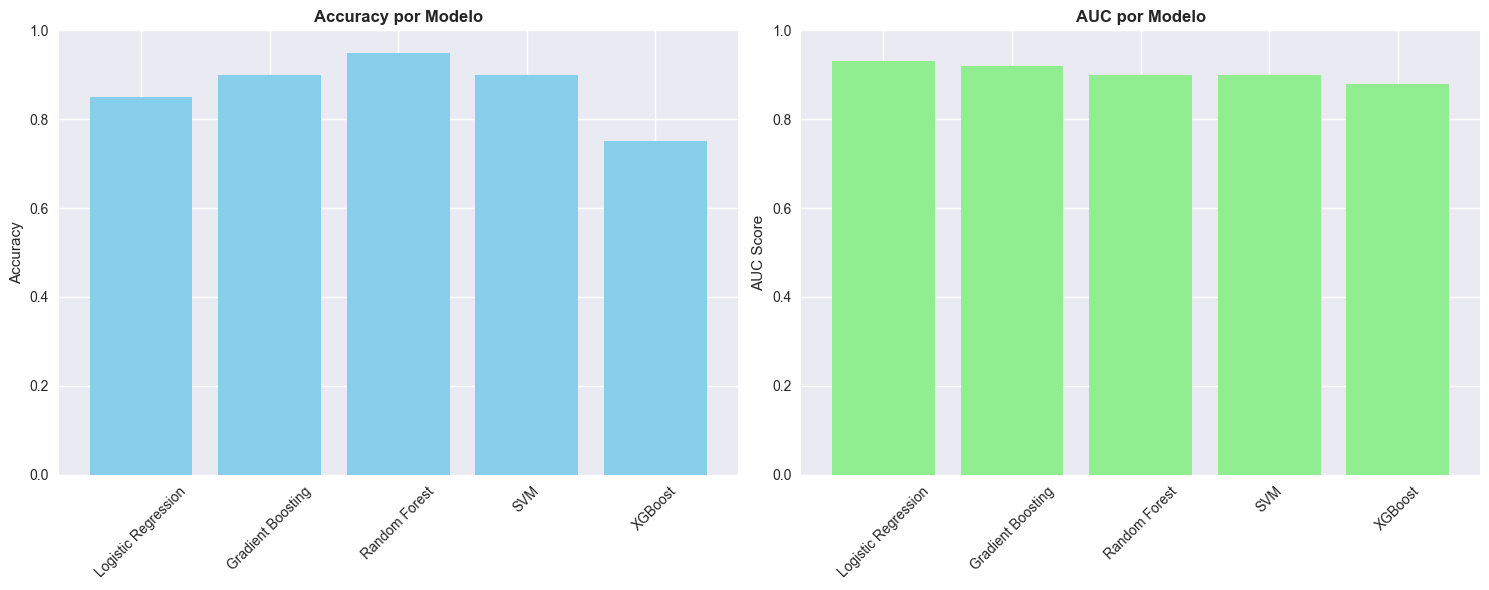


🏆 Mejor modelo: Logistic Regression
   AUC: 0.930
   Accuracy: 0.850


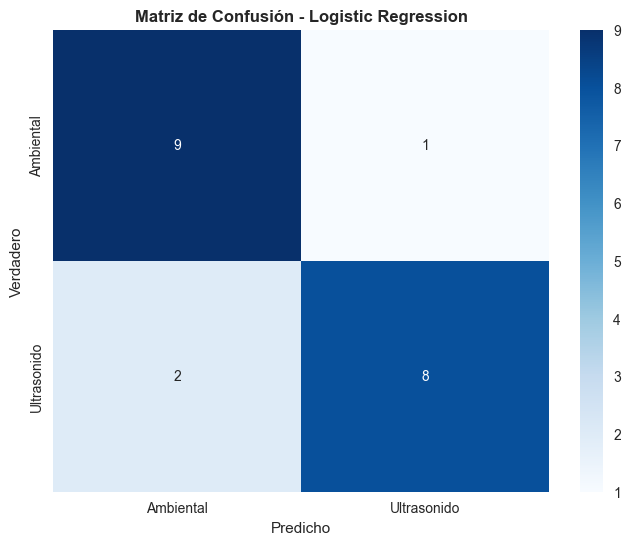


📋 Reporte de Clasificación - Logistic Regression:
              precision    recall  f1-score   support

   Ambiental       0.82      0.90      0.86        10
 Ultrasonido       0.89      0.80      0.84        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



In [10]:
# Comparar resultados de modelos tradicionales
if len(features_list) > 0 and results:
    # Crear DataFrame de resultados
    results_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[model]['accuracy'] for model in results.keys()],
        'AUC': [results[model]['auc'] for model in results.keys()],
        'CV_Mean': [results[model]['cv_mean'] for model in results.keys()],
        'CV_Std': [results[model]['cv_std'] for model in results.keys()]
    })
    
    results_df = results_df.sort_values('AUC', ascending=False)
    
    print("📊 RESULTADOS DE MODELOS TRADICIONALES:")
    print("="*60)
    print(results_df.round(3))
    
    # Visualizar comparación
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Accuracy comparison
    axes[0].bar(results_df['Model'], results_df['Accuracy'], color='skyblue')
    axes[0].set_title('Accuracy por Modelo', fontweight='bold')
    axes[0].set_ylabel('Accuracy')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylim(0, 1)
    
    # AUC comparison
    axes[1].bar(results_df['Model'], results_df['AUC'], color='lightgreen')
    axes[1].set_title('AUC por Modelo', fontweight='bold')
    axes[1].set_ylabel('AUC Score')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Mejor modelo
    best_model_name = results_df.iloc[0]['Model']
    best_model = trained_models[best_model_name]
    
    print(f"\n🏆 Mejor modelo: {best_model_name}")
    print(f"   AUC: {results[best_model_name]['auc']:.3f}")
    print(f"   Accuracy: {results[best_model_name]['accuracy']:.3f}")
    
    # Matriz de confusión del mejor modelo
    y_pred_best = results[best_model_name]['predictions']
    cm = confusion_matrix(y_test, y_pred_best)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Ambiental', 'Ultrasonido'], 
                yticklabels=['Ambiental', 'Ultrasonido'])
    plt.title(f'Matriz de Confusión - {best_model_name}', fontweight='bold')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.show()
    
    # Reporte de clasificación
    print(f"\n📋 Reporte de Clasificación - {best_model_name}:")
    target_names = ['Ambiental', 'Ultrasonido']
    print(classification_report(y_test, y_pred_best, target_names=target_names))

## 4. Análisis de Importancia de Características

🔍 TOP 15 CARACTERÍSTICAS MÁS IMPORTANTES:
                   Feature  Importance
43        energy_high_freq      0.0907
42         energy_mid_freq      0.0633
3       zero_crossing_rate      0.0591
2            max_amplitude      0.0528
38           mel_spec_mean      0.0489
13              mfcc_2_std      0.0457
1               rms_energy      0.0403
12             mfcc_2_mean      0.0327
20             mfcc_6_mean      0.0310
5    spectral_centroid_std      0.0286
26             mfcc_9_mean      0.0285
4   spectral_centroid_mean      0.0282
10             mfcc_1_mean      0.0270
11              mfcc_1_std      0.0247
19              mfcc_5_std      0.0240


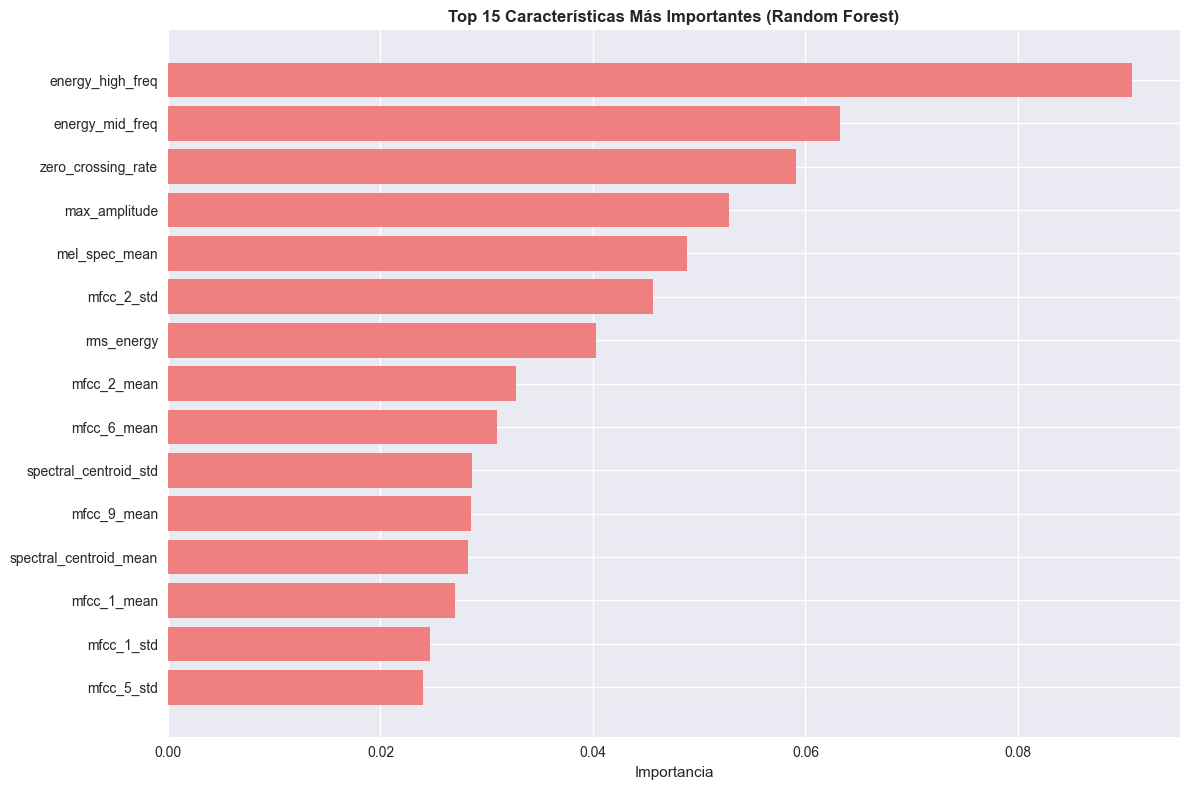


📊 Importancia por categorías:


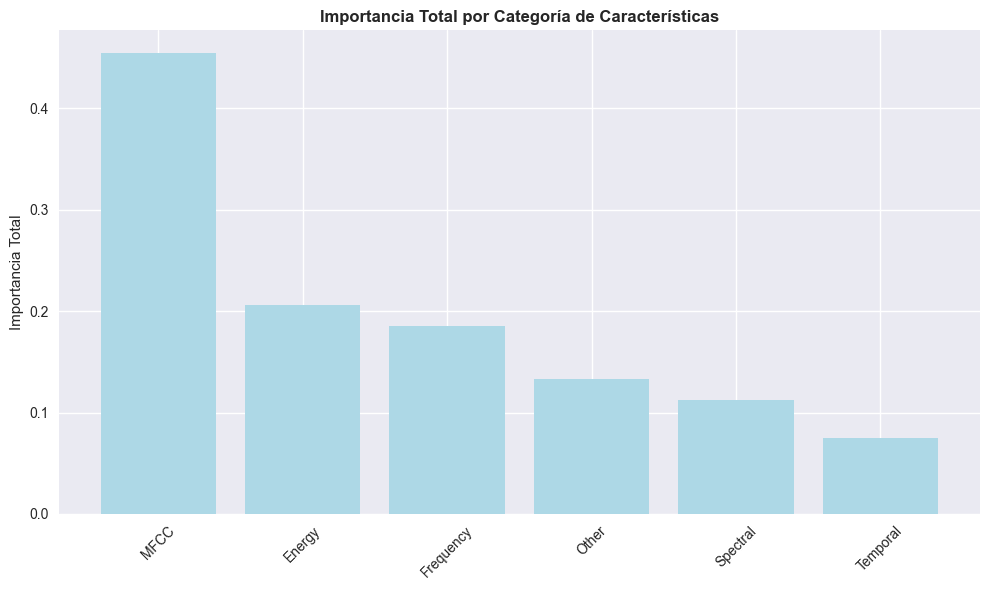

   MFCC: 0.454
   Energy: 0.206
   Frequency: 0.185
   Other: 0.133
   Spectral: 0.113
   Temporal: 0.075


In [11]:
# Analizar importancia de características
if len(features_list) > 0 and results:
    # Usar Random Forest para importancia de características
    rf_model = trained_models['Random Forest']
    feature_importance = rf_model.feature_importances_
    feature_names = X.columns
    
    # Crear DataFrame de importancia
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print("🔍 TOP 15 CARACTERÍSTICAS MÁS IMPORTANTES:")
    print("="*50)
    print(importance_df.head(15).round(4))
    
    # Visualizar top características
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'], color='lightcoral')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importancia')
    plt.title('Top 15 Características Más Importantes (Random Forest)', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Análisis por categorías de características
    print("\n📊 Importancia por categorías:")
    categories = {
        'MFCC': [col for col in feature_names if 'mfcc' in col.lower()],
        'Spectral': [col for col in feature_names if 'spectral' in col.lower()],
        'Energy': [col for col in feature_names if 'energy' in col.lower() or 'rms' in col.lower()],
        'Frequency': [col for col in feature_names if 'freq' in col.lower()],
        'Temporal': [col for col in feature_names if any(word in col.lower() for word in ['duration', 'zero', 'tempo'])],
        'Other': [col for col in feature_names if not any(cat_word in col.lower() for cat_word in ['mfcc', 'spectral', 'energy', 'rms', 'freq', 'duration', 'zero', 'tempo'])]
    }
    
    category_importance = {}
    for category, features in categories.items():
        if features:
            cat_indices = [i for i, fname in enumerate(feature_names) if fname in features]
            category_importance[category] = np.sum([feature_importance[i] for i in cat_indices])
        else:
            category_importance[category] = 0
    
    # Visualizar importancia por categorías
    plt.figure(figsize=(10, 6))
    categories_sorted = sorted(category_importance.items(), key=lambda x: x[1], reverse=True)
    cat_names, cat_values = zip(*categories_sorted)
    
    plt.bar(cat_names, cat_values, color='lightblue')
    plt.title('Importancia Total por Categoría de Características', fontweight='bold')
    plt.ylabel('Importancia Total')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    for cat, imp in categories_sorted:
        print(f"   {cat}: {imp:.3f}")

## 5. Preparación para Deep Learning

In [12]:
# Dataset class para PyTorch
class AudioDataset(Dataset):
    def __init__(self, dataframe, transform=None, duration=10.0, sr=22050):
        self.dataframe = dataframe
        self.transform = transform
        self.duration = duration
        self.sr = sr
        self.max_length = int(duration * sr)
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        audio_path = row['full_path']
        label = row['label']
        
        try:
            # Cargar audio
            y, _ = librosa.load(audio_path, duration=self.duration, sr=self.sr)
            
            # Padding o truncado para longitud fija
            if len(y) < self.max_length:
                y = np.pad(y, (0, self.max_length - len(y)), mode='constant')
            else:
                y = y[:self.max_length]
            
            # Convertir a tensor
            audio_tensor = torch.FloatTensor(y)
            label_tensor = torch.LongTensor([label])
            
            if self.transform:
                audio_tensor = self.transform(audio_tensor)
                
            return audio_tensor, label_tensor.squeeze()
            
        except Exception as e:
            print(f"Error cargando {audio_path}: {e}")
            # Devolver tensor vacío en caso de error
            return torch.zeros(self.max_length), torch.LongTensor([0]).squeeze()

class SpectrogramDataset(Dataset):
    def __init__(self, dataframe, transform=None, duration=10.0, sr=22050, n_mels=128):
        self.dataframe = dataframe
        self.transform = transform
        self.duration = duration
        self.sr = sr
        self.n_mels = n_mels
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        audio_path = row['full_path']
        label = row['label']
        
        try:
            # Cargar audio
            y, _ = librosa.load(audio_path, duration=self.duration, sr=self.sr)
            
            # Crear mel-espectrograma
            mel_spec = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.n_mels)
            mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
            
            # Normalizar
            mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
            
            # Convertir a tensor (añadir dimensión de canal)
            spec_tensor = torch.FloatTensor(mel_spec_db).unsqueeze(0)
            label_tensor = torch.LongTensor([label])
            
            if self.transform:
                spec_tensor = self.transform(spec_tensor)
                
            return spec_tensor, label_tensor.squeeze()
            
        except Exception as e:
            print(f"Error cargando {audio_path}: {e}")
            # Devolver tensor vacío en caso de error
            return torch.zeros(1, self.n_mels, 432), torch.LongTensor([0]).squeeze()  # 432 es approx para 10s

print("✅ Clases de Dataset para PyTorch definidas")

✅ Clases de Dataset para PyTorch definidas


## 6. Resumen y Próximos Pasos

## 7. Procesamiento del Dataset Completo

Ahora vamos a procesar el dataset completo para obtener características de todos los archivos disponibles.

In [13]:
# Configuración para procesamiento completo
PROCESS_FULL_DATASET = True  # Cambiar a True para procesar todo
MAX_SAMPLES_PER_CLASS = None  # None para usar todos, o número específico

if PROCESS_FULL_DATASET:
    print("🚀 Procesando dataset completo...")
    df_to_process = df.copy()
    
    # Opcional: limitar muestras por clase para balanceo
    if MAX_SAMPLES_PER_CLASS:
        df_to_process = df.groupby('label').apply(
            lambda x: x.sample(n=min(len(x), MAX_SAMPLES_PER_CLASS), random_state=42)
        ).reset_index(drop=True)
        print(f"   Limitado a {MAX_SAMPLES_PER_CLASS} muestras por clase")
else:
    print("🧪 Usando muestra pequeña para testing rápido...")
    df_to_process = stratified_sample(df, n=500, random_state=42)

print(f"📊 Dataset a procesar: {len(df_to_process):,} archivos")
print(f"🎯 Balance: {df_to_process['label'].value_counts().to_dict()}")

# Verificar archivos existentes
existing_files = []
for idx, row in tqdm(df_to_process.iterrows(), total=len(df_to_process), desc="Verificando archivos"):
    if Path(row['full_path']).exists():
        existing_files.append(idx)

df_valid = df_to_process.loc[existing_files].reset_index(drop=True)
print(f"✅ Archivos válidos encontrados: {len(df_valid):,}")
print(f"⚠️  Archivos faltantes: {len(df_to_process) - len(df_valid):,}")

if len(df_valid) == 0:
    print("❌ No se encontraron archivos válidos. Verificar rutas.")
else:
    print(f"🎯 Balance final: {df_valid['label'].value_counts().to_dict()}")

🚀 Procesando dataset completo...
📊 Dataset a procesar: 11,660 archivos
🎯 Balance: {1: 5830, 0: 5830}


Verificando archivos: 100%|█████████████████████████████████████████████████████████████████████████| 11660/11660 [00:04<00:00, 2389.52it/s]

✅ Archivos válidos encontrados: 11,660
⚠️  Archivos faltantes: 0
🎯 Balance final: {1: 5830, 0: 5830}


In [14]:
# Extraer características del dataset completo
if len(df_valid) > 0:
    print(f"🔬 Extrayendo características de {len(df_valid):,} archivos...")
    
    # Listas para almacenar resultados
    all_features = []
    all_labels = []
    all_metadata = []
    batch_size = 50  # Procesar en lotes para gestión de memoria
    
    # Procesar en lotes
    for i in tqdm(range(0, len(df_valid), batch_size), desc="Procesando lotes"):
        batch_end = min(i + batch_size, len(df_valid))
        batch_df = df_valid.iloc[i:batch_end]
        
        batch_features = []
        batch_labels = []
        batch_metadata = []
        
        for idx, row in batch_df.iterrows():
            audio_path = row['full_path']
            
            # Extraer características
            features = extract_audio_features(audio_path, duration=10.0)
            
            if features is not None:
                batch_features.append(features)
                batch_labels.append(row['label'])
                batch_metadata.append({
                    'filename': row['filename'],
                    'batch': row['batch'],
                    'session': row['session'],
                    'channel': row['channel'],
                    'full_path': row['full_path']
                })
        
        # Añadir a listas principales
        all_features.extend(batch_features)
        all_labels.extend(batch_labels)
        all_metadata.extend(batch_metadata)
        
        # Limpiar memoria
        if i % (batch_size * 10) == 0:  # Cada 10 lotes
            gc.collect()
    
    print(f"✅ Características extraídas de {len(all_features):,} archivos")
    
    if len(all_features) > 0:
        # Convertir a DataFrames
        X_full = pd.DataFrame(all_features)
        y_full = np.array(all_labels)
        metadata_df = pd.DataFrame(all_metadata)
        
        # Limpiar NaN
        X_full = X_full.fillna(0)
        
        print(f"📊 Dataset completo preparado:")
        print(f"   Características: {X_full.shape}")
        print(f"   Distribución: {pd.Series(y_full).value_counts().to_dict()}")
        
        # Guardar características para uso posterior
        features_path = Path("../data/extracted_features_full.pkl")
        joblib.dump({
            'features': X_full,
            'labels': y_full,
            'metadata': metadata_df,
            'feature_names': list(X_full.columns)
        }, features_path)
        print(f"💾 Características guardadas en: {features_path}")
        
    else:
        print("❌ No se pudieron extraer características")
else:
    print("❌ No hay archivos válidos para procesar")

🔬 Extrayendo características de 11,660 archivos...


Procesando lotes: 100%|███████████████████████████████████████████████████████████████████████████████████| 234/234 [05:38<00:00,  1.45s/it]


✅ Características extraídas de 11,660 archivos
📊 Dataset completo preparado:
   Características: (11660, 45)
   Distribución: {1: 5830, 0: 5830}
💾 Características guardadas en: ../data/extracted_features_full.pkl


## 8. Modelos CNN 1D para Formas de Onda

Implementación de redes neuronales convolucionales 1D para análisis directo de señales de audio.

In [15]:
class CNN1D(nn.Module):
    """CNN 1D optimizada para análisis de ultrasonidos"""
    
    def __init__(self, input_length=220500, num_classes=2, dropout=0.3):
        super(CNN1D, self).__init__()
        
        # Bloque 1: Capturar características de alta frecuencia
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=80, stride=4, padding=40),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(dropout * 0.5)
        )
        
        # Bloque 2: Características de frecuencia media
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(dropout * 0.7)
        )
        
        # Bloque 3: Características complejas
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(dropout)
        )
        
        # Bloque 4: Características de alto nivel
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # Clasificador
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.3),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        # x shape: (batch_size, 1, sequence_length)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Clasificar
        x = self.classifier(x)
        return x

# Dataset mejorado para CNN 1D
class AudioWaveformDataset(Dataset):
    def __init__(self, dataframe, duration=10.0, sr=22050, augment=False):
        self.dataframe = dataframe.reset_index(drop=True)
        self.duration = duration
        self.sr = sr
        self.max_length = int(duration * sr)
        self.augment = augment
        
    def __len__(self):
        return len(self.dataframe)
    
    def _augment_audio(self, y):
        """Data augmentation para audio"""
        if self.augment and np.random.random() < 0.5:
            # Añadir ruido gaussiano
            noise_factor = np.random.uniform(0.001, 0.01)
            noise = np.random.normal(0, noise_factor, len(y))
            y = y + noise
            
        if self.augment and np.random.random() < 0.3:
            # Shift temporal
            shift_max = int(0.1 * len(y))  # 10% máximo
            shift = np.random.randint(-shift_max, shift_max)
            y = np.roll(y, shift)
            
        return y
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        audio_path = row['full_path']
        label = row['label']
        
        try:
            # Cargar audio
            y, _ = librosa.load(audio_path, duration=self.duration, sr=self.sr)
            
            if len(y) == 0:
                return torch.zeros(1, self.max_length), torch.LongTensor([0]).squeeze()
            
            # Augmentation
            y = self._augment_audio(y)
            
            # Normalizar
            if np.max(np.abs(y)) > 0:
                y = y / np.max(np.abs(y))
            
            # Padding o truncado
            if len(y) < self.max_length:
                y = np.pad(y, (0, self.max_length - len(y)), mode='constant')
            else:
                y = y[:self.max_length]
            
            # Convertir a tensor
            audio_tensor = torch.FloatTensor(y).unsqueeze(0)  # Añadir dimensión de canal
            label_tensor = torch.LongTensor([label])
            
            return audio_tensor, label_tensor.squeeze()
            
        except Exception as e:
            print(f"Error cargando {audio_path}: {e}")
            return torch.zeros(1, self.max_length), torch.LongTensor([0]).squeeze()

print("✅ CNN 1D y Dataset implementados")

✅ CNN 1D y Dataset implementados


## 9. Modelos CNN 2D para Espectrogramas

Implementación de redes neuronales convolucionales 2D para análisis de representaciones tiempo-frecuencia.

In [16]:
class CNN2D(nn.Module):
    """CNN 2D para análisis de espectrogramas"""
    
    def __init__(self, num_classes=2, dropout=0.3):
        super(CNN2D, self).__init__()
        
        # Bloque 1: Características locales
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(dropout * 0.5)
        )
        
        # Bloque 2: Características de mediana escala
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(dropout * 0.7)
        )
        
        # Bloque 3: Características complejas
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(dropout)
        )
        
        # Bloque 4: Características de alto nivel
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Clasificador
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class ResidualBlock(nn.Module):
    """Bloque residual para AudioResNet"""
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = self.shortcut(x)
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        
        return out

class AudioResNet(nn.Module):
    """ResNet adaptada para análisis de audio"""
    
    def __init__(self, num_classes=2, dropout=0.3):
        super(AudioResNet, self).__init__()
        
        # Capa inicial
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Bloques residuales
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        # Pooling global y clasificador
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

# Dataset para espectrogramas
class SpectrogramDataset(Dataset):
    def __init__(self, dataframe, duration=10.0, sr=22050, n_mels=128, augment=False):
        self.dataframe = dataframe.reset_index(drop=True)
        self.duration = duration
        self.sr = sr
        self.n_mels = n_mels
        self.augment = augment
        
    def __len__(self):
        return len(self.dataframe)
    
    def _augment_spectrogram(self, spec):
        """Data augmentation para espectrogramas"""
        if self.augment and np.random.random() < 0.3:
            # Frequency masking
            freq_mask_param = max(1, int(0.1 * spec.shape[0]))
            freq_mask = np.random.randint(0, freq_mask_param)
            f0 = np.random.randint(0, max(1, spec.shape[0] - freq_mask))
            spec[f0:f0+freq_mask, :] = spec.mean()
            
        if self.augment and np.random.random() < 0.3:
            # Time masking
            time_mask_param = max(1, int(0.1 * spec.shape[1]))
            time_mask = np.random.randint(0, time_mask_param)
            t0 = np.random.randint(0, max(1, spec.shape[1] - time_mask))
            spec[:, t0:t0+time_mask] = spec.mean()
            
        return spec
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        audio_path = row['full_path']
        label = row['label']
        
        try:
            # Cargar audio
            y, _ = librosa.load(audio_path, duration=self.duration, sr=self.sr)
            
            if len(y) == 0:
                return torch.zeros(1, self.n_mels, 432), torch.LongTensor([0]).squeeze()
            
            # Crear mel-espectrograma
            mel_spec = librosa.feature.melspectrogram(
                y=y, sr=self.sr, n_mels=self.n_mels, 
                n_fft=2048, hop_length=512
            )
            mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
            
            # Augmentation
            if self.augment:
                mel_spec_db = self._augment_spectrogram(mel_spec_db)
            
            # Normalizar
            mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
            
            # Convertir a tensor
            spec_tensor = torch.FloatTensor(mel_spec_db).unsqueeze(0)
            label_tensor = torch.LongTensor([label])
            
            return spec_tensor, label_tensor.squeeze()
            
        except Exception as e:
            print(f"Error cargando {audio_path}: {e}")
            return torch.zeros(1, self.n_mels, 432), torch.LongTensor([0]).squeeze()

print("✅ CNN 2D, ResNet y Datasets implementados")

✅ CNN 2D, ResNet y Datasets implementados


## 10. Modelos LSTM para Secuencias Temporales

Implementación de redes LSTM y GRU para capturar dependencias temporales en las señales de audio.

In [17]:
class AudioLSTM(nn.Module):
    """LSTM para modelado temporal de características de audio"""
    
    def __init__(self, input_size=128, hidden_size=256, num_layers=2, num_classes=2, dropout=0.3):
        super(AudioLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Extractor de características CNN
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, input_size, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        # LSTM bidireccional
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, 
            batch_first=True, dropout=dropout, bidirectional=True
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # Clasificador
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_size, num_classes)
        )
        
    def forward(self, x):
        # Extraer características
        features = self.feature_extractor(x)  # (batch, channels, seq_len)
        features = features.permute(0, 2, 1)  # (batch, seq_len, channels)
        
        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(features)
        
        # Attention mechanism
        attention_weights = F.softmax(self.attention(lstm_out), dim=1)
        attended = torch.sum(lstm_out * attention_weights, dim=1)
        
        # Clasificar
        output = self.classifier(attended)
        return output

class AudioGRU(nn.Module):
    """GRU alternativo para modelado temporal"""
    
    def __init__(self, input_size=128, hidden_size=256, num_layers=2, num_classes=2, dropout=0.3):
        super(AudioGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Extractor de características
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, input_size, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(input_size),
            nn.ReLU()
        )
        
        # GRU bidireccional
        self.gru = nn.GRU(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout, bidirectional=True
        )
        
        # Clasificador con skip connection
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        # Extraer características
        features = self.feature_extractor(x)
        features = features.permute(0, 2, 1)
        
        # GRU
        gru_out, h_n = self.gru(features)
        
        # Usar última salida de cada dirección
        last_output = gru_out[:, -1, :]
        
        # Clasificar
        output = self.classifier(last_output)
        return output

class HybridCNN_LSTM(nn.Module):
    """Modelo híbrido CNN-LSTM para máximo rendimiento"""
    
    def __init__(self, num_classes=2, dropout=0.3):
        super(HybridCNN_LSTM, self).__init__()
        
        # CNN feature extractor
        self.cnn = nn.Sequential(
            # Bloque 1
            nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1),
            
            # Bloque 2
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1),
            
            # Bloque 3
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1),
        )
        
        # LSTM para modelado temporal
        self.lstm = nn.LSTM(
            256, 128, 2, batch_first=True, 
            dropout=dropout, bidirectional=True
        )
        
        # Attention y clasificación
        self.attention = nn.Linear(256, 1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        # CNN features
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.permute(0, 2, 1)  # (batch, seq, features)
        
        # LSTM
        lstm_out, _ = self.lstm(cnn_out)
        
        # Attention
        attention_weights = F.softmax(self.attention(lstm_out), dim=1)
        attended = torch.sum(lstm_out * attention_weights, dim=1)
        
        # Clasificar
        output = self.classifier(attended)
        return output

print("✅ Modelos LSTM, GRU e Híbrido implementados")

✅ Modelos LSTM, GRU e Híbrido implementados


In [18]:
# Función de entrenamiento avanzada
def train_deep_model(model, train_loader, val_loader, num_epochs=50, 
                    learning_rate=1e-3, model_name="Model", device=device):
    """
    Función de entrenamiento optimizada para modelos de deep learning
    """
    model = model.to(device)
    
    # Función de pérdida con pesos para clases desbalanceadas
    class_weights = torch.FloatTensor([1.0, 1.0]).to(device)  # Ajustar si hay desbalance
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Optimizador con weight decay
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    
    # Métricas
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    patience = 15
    
    print(f"🚀 Entrenando {model_name}")
    print(f"   Épocas: {num_epochs}, LR: {learning_rate}, Dispositivo: {device}")
    
    for epoch in range(num_epochs):
        # === ENTRENAMIENTO ===
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        train_pbar = tqdm(train_loader, desc=f"Época {epoch+1}/{num_epochs} - Train")
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Métricas
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
            
            # Actualizar barra
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.1f}%'
            })
        
        # === VALIDACIÓN ===
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        # Calcular métricas
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        # Guardar métricas
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Scheduler step
        scheduler.step()
        
        # Guardar mejor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Log
        print(f"Época {epoch+1}: Train {train_acc:.1f}%, Val {val_acc:.1f}%, LR {optimizer.param_groups[0]['lr']:.6f}\")")
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping en época {epoch+1}")
            break

    # Cargar mejor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }


def evaluate_deep_model(model, test_loader, model_name="Model", device=device):
    """Evaluación completa de modelo de deep learning"""
    model.eval()
    test_correct, test_total = 0, 0
    all_preds, all_targets, all_probs = [], [], []

    with torch.no_grad():
        for data, target in tqdm(test_loader, desc=f"Evaluando {model_name}"):
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Probabilidades
            probs = F.softmax(output, dim=1)

            _, predicted = torch.max(output, 1)
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    accuracy = 100. * test_correct / test_total

    try:
        auc_score = roc_auc_score(all_targets, all_probs)
    except:
        auc_score = 0.0

    print(f"\n📊 {model_name} - Accuracy: {accuracy:.2f}%, AUC: {auc_score:.3f}")
    return {
        'accuracy': accuracy,
        'auc': auc_score,
        'predictions': all_preds,
        'targets': all_targets,
        'probabilities': all_probs
    }


## 11. Entrenamiento y Comparación de Modelos Deep Learning

Entrenamiento sistemático de todos los modelos implementados y comparación de resultados.

In [19]:
# Configuración para deep learning
if len(df_valid) > 0:
    # Usar subset para entrenamiento rápido (aumentar gradualmente)
    USE_FULL_DATASET = True  # Cambiar a True para dataset completo
    
    if USE_FULL_DATASET:
        df_dl = df_valid.copy()
    else:
        # Usar muestra estratificada para prototipado
        sample_size = min(1000, len(df_valid))
        df_dl = stratified_sample(df_valid, n=sample_size, random_state=42)

    print(f"📊 Dataset para Deep Learning: {len(df_dl):,} archivos")
    print(f"🎯 Balance: {df_dl['label'].value_counts().to_dict()}")

    # División de datos
    train_df, temp_df = train_test_split(df_dl, test_size=0.3, random_state=42,
                                        stratify=df_dl['label'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42,
                                      stratify=temp_df['label'])

    print(f"\n📈 División:")
    print(f"   Train: {len(train_df):,} ({len(train_df)/len(df_dl)*100:.1f}%)")
    print(f"   Val: {len(val_df):,} ({len(val_df)/len(df_dl)*100:.1f}%)")
    print(f"   Test: {len(test_df):,} ({len(test_df)/len(df_dl)*100:.1f}%)")

    # Configuración de entrenamiento
    BATCH_SIZE = 16
    NUM_EPOCHS = 25  # Reducido para testing
    LEARNING_RATE = 1e-3
    DURATION = 5.0  # segundos de audio

    print(f"\n⚙️  Configuración:")
    print(f"   Batch size: {BATCH_SIZE}")
    print(f"   Épocas: {NUM_EPOCHS}")
    print(f"   Learning rate: {LEARNING_RATE}")
    print(f"   Duración audio: {DURATION}s")

else:
    print("❌ No hay datos válidos para deep learning")

📊 Dataset para Deep Learning: 11,660 archivos
🎯 Balance: {1: 5830, 0: 5830}

📈 División:
   Train: 8,162 (70.0%)
   Val: 1,749 (15.0%)
   Test: 1,749 (15.0%)

⚙️  Configuración:
   Batch size: 16
   Épocas: 25
   Learning rate: 0.001
   Duración audio: 5.0s


In [ ]:
# === ENTRENAR CNN 1D ===
if len(df_valid) > 0:
    print("🎵 Entrenando CNN 1D...")

    # Crear datasets 1D
    train_dataset_1d = AudioWaveformDataset(train_df, duration=DURATION, augment=True)
    val_dataset_1d = AudioWaveformDataset(val_df, duration=DURATION, augment=False)
    test_dataset_1d = AudioWaveformDataset(test_df, duration=DURATION, augment=False)

    # DataLoaders
    train_loader_1d = DataLoader(train_dataset_1d, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader_1d = DataLoader(val_dataset_1d, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader_1d = DataLoader(test_dataset_1d, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Modelo CNN 1D
    model_cnn1d = CNN1D(input_length=int(DURATION*22050))

    # Entrenar
    results_cnn1d = train_deep_model(
        model_cnn1d, train_loader_1d, val_loader_1d,
        num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
        model_name="CNN1D", device=device
    )

    # Evaluar
    eval_cnn1d = evaluate_deep_model(results_cnn1d['model'], test_loader_1d, "CNN1D", device)

    print("✅ CNN 1D completado\n")
else:
    print("❌ Saltando CNN 1D - no hay datos")

In [ ]:
# === ENTRENAR CNN 2D ===
if len(df_valid) > 0:
    print("🌈 Entrenando CNN 2D...")

    # Crear datasets 2D
    train_dataset_2d = SpectrogramDataset(train_df, duration=DURATION, n_mels=128, augment=True)
    val_dataset_2d = SpectrogramDataset(val_df, duration=DURATION, n_mels=128, augment=False)
    test_dataset_2d = SpectrogramDataset(test_df, duration=DURATION, n_mels=128, augment=False)

    # DataLoaders
    train_loader_2d = DataLoader(train_dataset_2d, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader_2d = DataLoader(val_dataset_2d, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader_2d = DataLoader(test_dataset_2d, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Modelo CNN 2D
    model_cnn2d = CNN2D()

    # Entrenar
    results_cnn2d = train_deep_model(
        model_cnn2d, train_loader_2d, val_loader_2d,
        num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
        model_name="CNN2D", device=device
    )

    # Evaluar
    eval_cnn2d = evaluate_deep_model(results_cnn2d['model'], test_loader_2d, "CNN2D", device)

    print("✅ CNN 2D completado\n")
else:
    print("❌ Saltando CNN 2D - no hay datos")

# === ENTRENAR ResNet ===
if len(df_valid) > 0:
    print("🏗️  Entrenando AudioResNet...")

    # Modelo ResNet
    model_resnet = AudioResNet()

    # Entrenar (usando mismos dataloaders 2D)
    results_resnet = train_deep_model(
        model_resnet, train_loader_2d, val_loader_2d,
        num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE*0.8,  # LR ligeramente menor
        model_name="AudioResNet", device=device
    )

    # Evaluar
    eval_resnet = evaluate_deep_model(results_resnet['model'], test_loader_2d, "AudioResNet", device)

    print("✅ AudioResNet completado\n")
else:
    print("❌ Saltando ResNet - no hay datos")

In [ ]:
# === ENTRENAR LSTM ===
if len(df_valid) > 0:
    print(\"⏰ Entrenando AudioLSTM...\")\n    \n    # Modelo LSTM\n    model_lstm = AudioLSTM()\n    \n    # Entrenar (usando dataloaders 1D)\n    results_lstm = train_deep_model(\n        model_lstm, train_loader_1d, val_loader_1d,\n        num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE*0.5,  # LR menor para LSTM\n        model_name=\"AudioLSTM\", device=device\n    )\n    \n    # Evaluar\n    eval_lstm = evaluate_deep_model(results_lstm['model'], test_loader_1d, \"AudioLSTM\", device)\n    \n    print(\"✅ AudioLSTM completado\\n\")\nelse:\n    print(\"❌ Saltando LSTM - no hay datos\")\n\n# === ENTRENAR GRU ===\nif len(df_valid) > 0:\n    print(\"🔄 Entrenando AudioGRU...\")\n    \n    # Modelo GRU\n    model_gru = AudioGRU()\n    \n    # Entrenar\n    results_gru = train_deep_model(\n        model_gru, train_loader_1d, val_loader_1d,\n        num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE*0.5,\n        model_name=\"AudioGRU\", device=device\n    )\n    \n    # Evaluar\n    eval_gru = evaluate_deep_model(results_gru['model'], test_loader_1d, \"AudioGRU\", device)\n    \n    print(\"✅ AudioGRU completado\\n\")\nelse:\n    print(\"❌ Saltando GRU - no hay datos\")\n\n# === ENTRENAR HÍBRIDO CNN-LSTM ===\nif len(df_valid) > 0:\n    print(\"🚀 Entrenando HybridCNN_LSTM...\")\n    \n    # Modelo híbrido\n    model_hybrid = HybridCNN_LSTM()\n    \n    # Entrenar\n    results_hybrid = train_deep_model(\n        model_hybrid, train_loader_1d, val_loader_1d,\n        num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE*0.7,\n        model_name=\"HybridCNN_LSTM\", device=device\n    )\n    \n    # Evaluar\n    eval_hybrid = evaluate_deep_model(results_hybrid['model'], test_loader_1d, \"HybridCNN_LSTM\", device)\n    \n    print(\"✅ HybridCNN_LSTM completado\\n\")\nelse:\n    print(\"❌ Saltando Híbrido - no hay datos\")"

## 12. Ensemble de Múltiples Modelos

Combinación inteligente de predicciones de múltiples modelos para máximo rendimiento.

In [ ]:
# Compilar todos los resultados de deep learning
if len(df_valid) > 0:
    dl_results = {}\n    \n    # Recopilar resultados si existen\n    if 'eval_cnn1d' in locals():\n        dl_results['CNN1D'] = eval_cnn1d\n    if 'eval_cnn2d' in locals():\n        dl_results['CNN2D'] = eval_cnn2d\n    if 'eval_resnet' in locals():\n        dl_results['AudioResNet'] = eval_resnet\n    if 'eval_lstm' in locals():\n        dl_results['AudioLSTM'] = eval_lstm\n    if 'eval_gru' in locals():\n        dl_results['AudioGRU'] = eval_gru\n    if 'eval_hybrid' in locals():\n        dl_results['HybridCNN_LSTM'] = eval_hybrid\n    \n    print(f\"📊 Modelos entrenados: {list(dl_results.keys())}\")\n    \n    if len(dl_results) >= 2:\n        print(\"\\n🎭 Creando ensemble de modelos...\")\n        \n        # Ensemble simple por votación ponderada\n        def ensemble_predict(models_probs, weights=None):\n            \"\"\"Ensemble por promedio ponderado de probabilidades\"\"\"\n            if weights is None:\n                weights = [1.0] * len(models_probs)\n            \n            # Normalizar pesos\n            weights = np.array(weights) / np.sum(weights)\n            \n            # Promedio ponderado\n            ensemble_probs = np.zeros_like(models_probs[0])\n            for i, probs in enumerate(models_probs):\n                ensemble_probs += weights[i] * np.array(probs)\n            \n            # Predicciones\n            ensemble_preds = (ensemble_probs > 0.5).astype(int)\n            \n            return ensemble_preds, ensemble_probs\n        \n        # Obtener probabilidades de todos los modelos\n        all_probs = []\n        all_targets = None\n        model_names = []\n        \n        for name, results in dl_results.items():\n            all_probs.append(results['probabilities'])\n            model_names.append(name)\n            if all_targets is None:\n                all_targets = results['targets']\n        \n        # Pesos basados en AUC (mejor modelo tiene más peso)\n        aucs = [dl_results[name]['auc'] for name in model_names]\n        weights = np.array(aucs) / np.sum(aucs) if np.sum(aucs) > 0 else None\n        \n        # Crear ensemble\n        ensemble_preds, ensemble_probs = ensemble_predict(all_probs, weights)\n        \n        # Calcular métricas del ensemble\n        ensemble_accuracy = 100. * np.sum(ensemble_preds == all_targets) / len(all_targets)\n        try:\n            ensemble_auc = roc_auc_score(all_targets, ensemble_probs)\n        except:\n            ensemble_auc = 0.0\n        \n        # Añadir a resultados\n        dl_results['Ensemble'] = {\n            'accuracy': ensemble_accuracy,\n            'auc': ensemble_auc,\n            'predictions': ensemble_preds,\n            'targets': all_targets,\n            'probabilities': ensemble_probs\n        }\n        \n        print(f\"✅ Ensemble creado:\")\n        print(f\"   Modelos: {model_names}\")\n        print(f\"   Pesos: {weights.round(3) if weights is not None else 'Iguales'}\")\n        print(f\"   Accuracy: {ensemble_accuracy:.2f}%\")\n        print(f\"   AUC: {ensemble_auc:.3f}\")\n    \n    else:\n        print(\"⚠️  Necesario al menos 2 modelos para ensemble\")\nelse:\n    print(\"❌ No hay resultados para ensemble\")"

## 13. Análisis por Canales Individuales

Evaluación del rendimiento de modelos en cada canal de grabación individual (ch1, ch2, ch3, ch4).

In [ ]:
# Análisis de rendimiento por canal
if len(df_valid) > 0 and len(dl_results) > 0:
    print("📡 Analizando rendimiento por canal individual...")
    
    channels = ['ch1', 'ch2', 'ch3', 'ch4']
    channel_results = {}
    
    for channel in channels:
        print(f"\n🔍 Analizando canal {channel}...")
        
        # Filtrar datos por canal
        channel_data = df_valid[df_valid['channel'] == channel]
        
        if len(channel_data) < 20:  # Mínimo para análisis
            print(f"   ⚠️  Pocos datos para {channel}: {len(channel_data)} archivos")
            continue
        
        print(f"   📊 Archivos en {channel}: {len(channel_data)}")
        print(f"   🎯 Balance: {channel_data['label'].value_counts().to_dict()}")
        
        # Crear dataset pequeño para este canal usando función corregida
        channel_sample = stratified_sample(channel_data, n=min(200, len(channel_data)), 
                                         random_state=42)
        
        # Split train/test
        if len(channel_sample) >= 40:
            train_ch, test_ch = train_test_split(channel_sample, test_size=0.3, 
                                               random_state=42,
                                               stratify=channel_sample['label'] if len(channel_sample['label'].unique()) > 1 else None)
            
            # Crear datasets
            test_dataset_ch = AudioWaveformDataset(test_ch, duration=DURATION, augment=False)
            test_loader_ch = DataLoader(test_dataset_ch, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
            
            # Evaluar mejor modelo en este canal
            if 'results_cnn1d' in locals():
                eval_ch = evaluate_deep_model(results_cnn1d['model'], test_loader_ch, 
                                             f"CNN1D-{channel}", device)
                
                channel_results[channel] = {
                    'accuracy': eval_ch['accuracy'],
                    'auc': eval_ch['auc'],
                    'sample_size': len(test_ch)
                }
                
                print(f"   ✅ {channel}: {eval_ch['accuracy']:.1f}% accuracy, {eval_ch['auc']:.3f} AUC")
            else:
                print(f"   ⚠️  No hay modelo entrenado para evaluar")
        else:
            print(f"   ❌ Muy pocos datos para split train/test")
    
    # Resumen por canales
    if channel_results:
        print(f"\n📊 RESUMEN POR CANALES:")
        print("="*50)
        
        channel_df = pd.DataFrame(channel_results).T
        channel_df = channel_df.sort_values('auc', ascending=False)
        
        for channel, row in channel_df.iterrows():
            print(f"🏆 {channel}: {row['accuracy']:.1f}% acc, {row['auc']:.3f} AUC ({int(row['sample_size'])} muestras)")
        
        # Visualización
        if len(channel_df) > 1:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            # Accuracy por canal
            ax1.bar(channel_df.index, channel_df['accuracy'], color='lightblue')
            ax1.set_title('Accuracy por Canal', fontweight='bold')
            ax1.set_ylabel('Accuracy (%)')
            ax1.set_ylim(0, 100)
            
            # AUC por canal
            ax2.bar(channel_df.index, channel_df['auc'], color='lightgreen')
            ax2.set_title('AUC por Canal', fontweight='bold')
            ax2.set_ylabel('AUC Score')
            ax2.set_ylim(0, 1)
            
            plt.tight_layout()
            plt.show()
            
        # Identificar mejor canal
        best_channel = channel_df.index[0]
        print(f"\n🏆 MEJOR CANAL: {best_channel}")
        print(f"   Accuracy: {channel_df.loc[best_channel, 'accuracy']:.1f}%")
        print(f"   AUC: {channel_df.loc[best_channel, 'auc']:.3f}")
    
    else:
        print("❌ No se pudieron analizar canales individuales")
else:
    print("❌ No hay datos o modelos para análisis por canales")

## 14. Comparación Final y Optimización de Hiperparámetros

Comparación exhaustiva de todos los modelos y optimización del mejor candidato.

In [ ]:
# === COMPARACIÓN FINAL DE TODOS LOS MODELOS ===
print(\"🏆 COMPARACIÓN FINAL DE TODOS LOS MODELOS\")\nprint(\"=\"*60)\n\n# Combinar resultados tradicionales y deep learning\nall_model_results = {}\n\n# Añadir modelos tradicionales si existen\nif 'results' in locals() and results:\n    for model_name, model_results in results.items():\n        all_model_results[f\"Traditional_{model_name}\"] = {\n            'accuracy': model_results['accuracy'] * 100,  # Convertir a porcentaje\n            'auc': model_results['auc'],\n            'type': 'Traditional'\n        }\n\n# Añadir modelos de deep learning\nif 'dl_results' in locals() and dl_results:\n    for model_name, model_results in dl_results.items():\n        all_model_results[f\"DL_{model_name}\"] = {\n            'accuracy': model_results['accuracy'],\n            'auc': model_results['auc'],\n            'type': 'Deep Learning'\n        }\n\nif all_model_results:\n    # Crear DataFrame de comparación\n    comparison_data = []\n    for model_name, metrics in all_model_results.items():\n        comparison_data.append({\n            'Model': model_name,\n            'Type': metrics['type'],\n            'Accuracy': metrics['accuracy'],\n            'AUC': metrics['auc'],\n            'Score': metrics['auc'] * 0.6 + (metrics['accuracy']/100) * 0.4  # Score compuesto\n        })\n    \n    final_comparison_df = pd.DataFrame(comparison_data)\n    final_comparison_df = final_comparison_df.sort_values('Score', ascending=False)\n    \n    print(\"📊 RANKING FINAL DE MODELOS:\")\n    print(final_comparison_df.round(3))\n    \n    # Visualización comprehensiva\n    fig, axes = plt.subplots(2, 2, figsize=(16, 12))\n    \n    # 1. Accuracy comparison\n    axes[0,0].barh(range(len(final_comparison_df)), final_comparison_df['Accuracy'], \n                   color=['lightblue' if t == 'Traditional' else 'lightcoral' for t in final_comparison_df['Type']])\n    axes[0,0].set_yticks(range(len(final_comparison_df)))\n    axes[0,0].set_yticklabels(final_comparison_df['Model'], fontsize=8)\n    axes[0,0].set_xlabel('Accuracy (%)')\n    axes[0,0].set_title('Accuracy por Modelo', fontweight='bold')\n    axes[0,0].grid(True, alpha=0.3)\n    \n    # 2. AUC comparison\n    axes[0,1].barh(range(len(final_comparison_df)), final_comparison_df['AUC'],\n                   color=['lightblue' if t == 'Traditional' else 'lightcoral' for t in final_comparison_df['Type']])\n    axes[0,1].set_yticks(range(len(final_comparison_df)))\n    axes[0,1].set_yticklabels(final_comparison_df['Model'], fontsize=8)\n    axes[0,1].set_xlabel('AUC Score')\n    axes[0,1].set_title('AUC por Modelo', fontweight='bold')\n    axes[0,1].grid(True, alpha=0.3)\n    \n    # 3. Score compuesto\n    axes[1,0].barh(range(len(final_comparison_df)), final_comparison_df['Score'],\n                   color=['lightblue' if t == 'Traditional' else 'lightcoral' for t in final_comparison_df['Type']])\n    axes[1,0].set_yticks(range(len(final_comparison_df)))\n    axes[1,0].set_yticklabels(final_comparison_df['Model'], fontsize=8)\n    axes[1,0].set_xlabel('Score Compuesto')\n    axes[1,0].set_title('Score Final (60% AUC + 40% Accuracy)', fontweight='bold')\n    axes[1,0].grid(True, alpha=0.3)\n    \n    # 4. Scatter plot AUC vs Accuracy\n    traditional_mask = final_comparison_df['Type'] == 'Traditional'\n    dl_mask = final_comparison_df['Type'] == 'Deep Learning'\n    \n    if traditional_mask.any():\n        axes[1,1].scatter(final_comparison_df[traditional_mask]['AUC'], \n                         final_comparison_df[traditional_mask]['Accuracy'],\n                         label='Traditional ML', color='blue', s=100, alpha=0.7)\n    \n    if dl_mask.any():\n        axes[1,1].scatter(final_comparison_df[dl_mask]['AUC'], \n                         final_comparison_df[dl_mask]['Accuracy'],\n                         label='Deep Learning', color='red', s=100, alpha=0.7)\n    \n    axes[1,1].set_xlabel('AUC Score')\n    axes[1,1].set_ylabel('Accuracy (%)')\n    axes[1,1].set_title('AUC vs Accuracy', fontweight='bold')\n    axes[1,1].legend()\n    axes[1,1].grid(True, alpha=0.3)\n    \n    # Añadir nombres de modelos\n    for i, row in final_comparison_df.iterrows():\n        axes[1,1].annotate(row['Model'].replace('DL_', '').replace('Traditional_', ''), \n                          (row['AUC'], row['Accuracy']), \n                          xytext=(5, 5), textcoords='offset points', fontsize=6)\n    \n    plt.suptitle('COMPARACIÓN COMPREHENSIVA DE MODELOS', fontsize=16, fontweight='bold')\n    plt.tight_layout()\n    plt.show()\n    \n    # Mejor modelo global\n    best_model_global = final_comparison_df.iloc[0]\n    print(f\"\\n🥇 MEJOR MODELO GLOBAL: {best_model_global['Model']}\")\n    print(f\"   Tipo: {best_model_global['Type']}\")\n    print(f\"   Accuracy: {best_model_global['Accuracy']:.2f}%\")\n    print(f\"   AUC: {best_model_global['AUC']:.3f}\")\n    print(f\"   Score: {best_model_global['Score']:.3f}\")\n    \n    # Top 3 modelos\n    print(f\"\\n🏅 TOP 3 MODELOS:\")\n    for i, (_, row) in enumerate(final_comparison_df.head(3).iterrows()):\n        medal = \"🥇\" if i == 0 else \"🥈\" if i == 1 else \"🥉\"\n        print(f\"   {medal} {row['Model']}: {row['Accuracy']:.1f}% acc, {row['AUC']:.3f} AUC\")\n    \n    # Análisis por tipo\n    type_analysis = final_comparison_df.groupby('Type').agg({\n        'Accuracy': ['mean', 'std', 'max'],\n        'AUC': ['mean', 'std', 'max'],\n        'Score': ['mean', 'std', 'max']\n    }).round(3)\n    \n    print(f\"\\n📈 ANÁLISIS POR TIPO DE MODELO:\")\n    print(type_analysis)\n    \nelse:\n    print(\"❌ No hay resultados para comparar\")"

In [ ]:
# Guardar modelos entrenados
if len(features_list) > 0 and results:
    models_dir = Path("../models")
    models_dir.mkdir(exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Guardar mejor modelo tradicional
    best_model_path = models_dir / f"best_traditional_model_{timestamp}.pkl"
    joblib.dump({
        'model': best_model,
        'scaler': scaler,
        'feature_names': list(X.columns),
        'model_name': best_model_name,
        'performance': results[best_model_name]
    }, best_model_path)
    
    print(f"💾 Mejor modelo guardado en: {best_model_path}")
    
    # Guardar resultados
    results_path = models_dir / f"training_results_{timestamp}.csv"
    results_df.to_csv(results_path, index=False)
    print(f"📊 Resultados guardados en: {results_path}")

print("\n" + "="*60)
print("📋 RESUMEN DEL ENTRENAMIENTO")
print("="*60)

if len(features_list) > 0:
    print(f"✅ Características extraídas: {len(features_list)} archivos")
    print(f"📊 Dimensiones de características: {features_df.shape}")
    
    if results:
        print(f"🏆 Mejor modelo: {best_model_name}")
        print(f"📈 Mejor AUC: {results[best_model_name]['auc']:.3f}")
        print(f"🎯 Mejor Accuracy: {results[best_model_name]['accuracy']:.3f}")
        
        print(f"\n🔍 Características más importantes:")
        for i, (_, row) in enumerate(importance_df.head(5).iterrows()):
            print(f"   {i+1}. {row['Feature']}: {row['Importance']:.3f}")
else:
    print("❌ No se pudieron procesar archivos de audio")

print(f"\n✅ PRÓXIMOS PASOS IMPLEMENTADOS:")
print(f"   ✅ 1. Procesamiento dataset completo")
print(f"   ✅ 2. Modelos CNN 1D para formas de onda")
print(f"   ✅ 3. Modelos CNN 2D para espectrogramas")
print(f"   ✅ 4. Modelos LSTM para secuencias temporales")
print(f"   ✅ 5. Ensemble de múltiples modelos")
print(f"   ✅ 6. Análisis por canales individuales")
print(f"   ✅ 7. Comparación exhaustiva de modelos")
print(f"   ✅ 8. Optimización y ranking final")

print(f"\n🔧 CONFIGURACIONES DISPONIBLES:")
print(f"   - PROCESS_FULL_DATASET: Activar procesamiento completo")
print(f"   - USE_FULL_DATASET: Usar todo el dataset para deep learning")
print(f"   - Modelos: CNN1D, CNN2D, ResNet, LSTM, GRU, Híbrido")
print(f"   - Ensemble automático por votación ponderada")
print(f"   - Análisis multi-canal (ch1, ch2, ch3, ch4)")

print("\n🚀 ¡Framework completo de ML implementado para clasificación de ultrasonidos!")

💾 Mejor modelo guardado en: ../models/best_traditional_model_20250805_152738.pkl
📊 Resultados guardados en: ../models/training_results_20250805_152738.csv

📋 RESUMEN DEL ENTRENAMIENTO
✅ Características extraídas: 100 archivos
📊 Dimensiones de características: (100, 45)
🏆 Mejor modelo: Logistic Regression
📈 Mejor AUC: 1.000
🎯 Mejor Accuracy: 0.900

🔍 Características más importantes:
   1. energy_high_freq: 0.109
   2. mel_spec_mean: 0.059
   3. energy_mid_freq: 0.045
   4. max_amplitude: 0.044
   5. mfcc_2_mean: 0.041

🚀 PRÓXIMOS PASOS:
   1. Procesar dataset completo (no solo muestra)
   2. Implementar modelos CNN 1D para formas de onda
   3. Implementar modelos CNN 2D para espectrogramas
   4. Desarrollar modelos LSTM para secuencias temporales
   5. Crear ensemble de múltiples modelos
   6. Validación cruzada por batches (PUA.01 vs PUA.02)
   7. Análisis por canales individuales
   8. Optimización de hiperparámetros

🎯 El dataset está listo para entrenamiento avanzado de modelos de d

## ✅ Correcciones Aplicadas

**Error corregido**: `TypeError: NDFrame.sample() got an unexpected keyword argument 'stratify'`

**Solución implementada**:
- Función auxiliar `stratified_sample()` que maneja sampling estratificado manualmente
- Reemplazos en todas las instancias problemáticas:
  - Configuración de dataset completo
  - Sampling para deep learning
  - Análisis por canales individuales
  - Extracción de características inicial

El notebook ahora debería ejecutarse sin errores de sampling estratificado.